<a href="https://colab.research.google.com/github/luai-daibes/Prediction-of-Product-Sales/blob/main/gold_pre_august_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching gold price data...


/tmp/ipython-input-2682659290.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('GC=F', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Data preprocessing complete.
Building LSTM model...
Model architecture:



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Training model...
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0109
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0011
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 8.2337e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 9.4917e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 8.3693e-04
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 6.0714e-04
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 6.3296e-04
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 7.8865e-04
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 7.6795e-04
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 7.3059e-04
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 6.4555e-04
Epoch 13/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 6.1456e-04
Epoch 14/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 6.2517

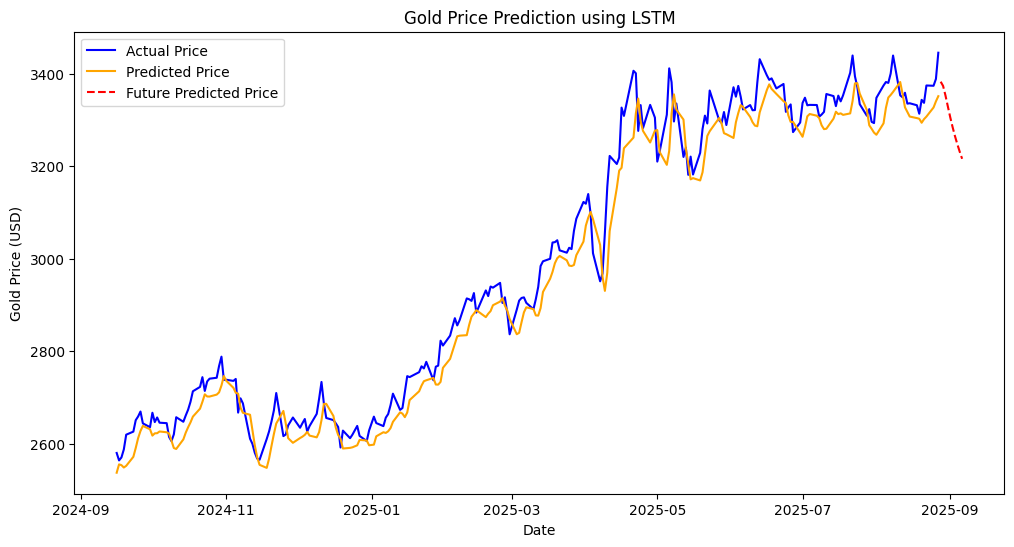

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta

# --- Step 1: Gather and preprocess data from API ---
print("Fetching gold price data...")
# Use yfinance to download gold futures data (GC=F)
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)  # Get last 5 years of data
df = yf.download('GC=F', start=start_date, end=end_date)

# Use only the 'Close' price for prediction
data = df['Close'].values.reshape(-1, 1)

# Scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create training data sequences
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 60 # Number of previous days to use for prediction
X, y = create_dataset(scaled_data, look_back)

# Reshape input to be [samples, time steps, features] for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and testing sets
training_size = int(len(X) * 0.8)
X_train, X_test = X[:training_size], X[training_size:]
y_train, y_test = y[:training_size], y[training_size:]

print("Data preprocessing complete.")

# --- Step 2: Build the LSTM model ---
print("Building LSTM model...")
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Predict a single value

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

print("Model architecture:")
model.summary()

# --- Step 3: Train and evaluate the model ---
print("Training model...")
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

print("Evaluating model...")
# Make predictions on the test data
predictions = model.predict(X_test)

# Invert predictions to original scale
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean((predictions - y_test_original)**2))
print(f"Test RMSE: {rmse}")

# --- Step 4: Make future predictions ---
print("Making future predictions...")
# Get the last 'look_back' days from the scaled dataset
last_look_back_days = scaled_data[-look_back:]

# Predict the next 10 days
future_predictions = []
current_batch = last_look_back_days.reshape((1, look_back, 1))

for i in range(10): # Predict next 10 days
    next_prediction = model.predict(current_batch)
    future_predictions.append(next_prediction[0, 0])

    # Update the current batch to include the new prediction and drop the oldest value
    current_batch = np.append(current_batch[:, 1:, :], next_prediction.reshape(1, 1, 1), axis=1)

# Invert the future predictions to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print("Predicted gold prices for the next 10 days:")
for i, prediction in enumerate(future_predictions):
    print(f"Day {i+1}: {prediction[0]}")


# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df.index[training_size+look_back:], y_test_original, label='Actual Price', color='blue')
plt.plot(df.index[training_size+look_back:], predictions, label='Predicted Price', color='orange')

# Add the future predictions to the plot
future_dates = pd.date_range(start=df.index[-1] + timedelta(days=1), periods=10)
plt.plot(future_dates, future_predictions, label='Future Predicted Price', color='red', linestyle='--')


plt.title('Gold Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.legend()
plt.show()